# Data Science and Visualization (RUC F2023)

## Miniproject Report

## Project Title: Energy consumption of algorithms and evaluation of data

## Group Members:
* [Mathias, computer science and informatics, 3rd year, mamaar@ruc.dk]
* [Martin, computer science and informatics, 3rd year, sundman@ruc.dk]


## Abstract

[Here, you need to write ~5 sentences to describe the main points of your project, including but not limited to, dataset, research questions, data science methods, findings from the data, your condlusions and remarks.]

The dataset is the result of an experiment measuring energy consumption of sorting algorithms. 
We are investigating how time complexity affects energy consumption of algorithms. 
We model the data using polynomial regression calculating the $R^2$ value to find the best fit.
Findings
Conclusion


## 0. Setup and Data

Import the modules needed for the project.

In [121]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# QUESTIONS

-   what is feature selection (section 4.1)
-   how do we get the function describing the polynomial gotten from the regression (section 4.1)
-   memeory doesnt work (section 1)


### Data description:

[Here you should provide a description of your dataset and where to find the dataset.]
The data loaded in the next cell is data gathered by our bachelor project group. In this project we are investigating energy consumption of algorithms run on specific laptops. The data is gathered with a tool supported by Intel processers called 'Running Average Power Limit' (RAPL). To understand full where the energy consumption comes from the resulting CSV containging the data will have these columns: 

RAPLCSV = [Test Name, PKG (J), CPU (J), GPU (J), Memory (J),Temperature (&deg;C), Time (ms)]


Further more, the memory consumption of the algorithmic run is extracted to a different CSV, due to impracticalities in the test repository on git: https://github.com/hrallil/RAPL_measurements

Memory = [Memory (byte)]

These two will be bound into one dataFrame with columns: 

df = ``[Test Name, PKG (J), CPU (J), GPU (J), Memory (J),Temperature (``&deg;``C), Time (ms), Memory (byte), Size]``

#### Column desctiption:
-    `Test Name` is the name of a sample and is use as an identifyer/key for that sample. 
-    ``PKG (J)`` contains the total power consumption of the socket.
-    ``CPU (J)`` Contains the power consumption of the CPU cores of the socket.
-    ``GPU (J)`` Contains the power consumption of the integrated graphics accociated with the socket. IS NOT USED since the test laptops do not have GPU's.
-    ``Memory (J)`` contains the power consumption of the memory controller in the socket.
-    ``Temperature (``&deg;``C)`` contains the temperature of the socket.
-    ``Time (ms)`` contains the walltime of this sample.
-    ``Memory (byte)`` contains memory consumption of this sample.
-    ``Size`` contains the Size of the input array for the specific sample.



## 1. Loading the Data

In [122]:
df = pd.read_csv("data/mergeSort-PC16.csv") 
df.columns=["Test name","PKG (J)","CPU (J)","GPU (J)","Memory (J)","Temperature","Time (ms)"]
l = []
dfMemory = pd.DataFrame(l.append(i) for i in range(11600))
dfMemory = pd.read_csv("data/MergeSortMemory-PC16.csv") #What in the fuck 15249696.1 ? 


dfMemory = dfMemory.transpose()

dfMemory["Memory (byte)"] = dfMemory.index

dfMemory = dfMemory.reset_index()
l = []
for i in range(len(dfMemory["Memory (byte)"])):
    l.append(int(float(dfMemory["Memory (byte)"][i])))

l
df["Memory (byte)"] = l


df


,Test name,PKG (J),CPU (J),GPU (J),Memory (J),Temperature,Time (ms),Memory (byte)
0,random1-25000-1,2.086792,1.796448,,0.131958,38,247.946,3393216
1,random1-25000-1,2.237671,1.952087,,0.138672,38,234.279,3391896
2,random1-25000-1,2.227417,1.941711,,0.142029,38,237.194,3397320
3,random1-25000-1,2.227234,1.935608,,0.140259,38,232.236,3385072
4,random1-25000-1,2.076599,1.804749,,0.129883,38,227.670,3396008
...,...,...,...,...,...,...,...,...
18794,random10-1000000-1,8.915527,7.729553,,0.477112,68,1024.890,142964344
18795,random10-1000000-1,9.108032,7.892151,,0.495239,68,1035.310,142429824
18796,random10-1000000-1,8.649841,7.518066,,0.475403,67,962.433,19941920
18797,random10-1000000-1,8.933716,7.770569,,0.468750,67,1000.870,17307600


## 2. Data Preprocessing

In this section, the data will show the missing data as NaN and will output how much missing data we have. 
Further more, this section will also consider if the values in the dataset are nonense, for instance if the energy consumption of one sample is below 0, we consider it nonsense and an error point made during reading. 

Finally, the data will also have the final column appended, ``Size``. This column is extracted from the column ``Test name``

In [123]:
#removing values that are nonsense 
df = df[df['PKG (J)'] >= 0]
df = df[df['CPU (J)'] >= 0]
#df = df[df['Memory (byte)'] >= 0.0]
df = df[df['Temperature'] >= 0.0]
df = df[df['Time (ms)'] >= 0.0]

df = df.replace("  ", np.nan)

#missing values for each column
print("MISSING DATA: \n\n ", df.isnull().sum(axis=0))

l = []
for i in range(len(df)):
    l.append(int(df.iloc[i]["Test name"].split("-")[1]))

df["Size"] = l

MISSING DATA: 

  Test name            0
PKG (J)              0
CPU (J)              0
GPU (J)          18799
Memory (J)           0
Temperature          0
Time (ms)            0
Memory (byte)        0
dtype: int64


Since the laptops do not contain a GPU, we expect missing data on GPU(j). 
Now that the data has been checked for missing data, we want to seperate the data into different sub-datasets. 

These sets will contain samples from each input type, which includes Best case input, worst case input and random input. 

Further more, random input has 10 different randoms to ensure that the one random that the system was tested on was not just a "lucky random".

In [124]:
#random input seperated into a list, where each element is a DataFrame containing that random CSVs output
listOfRandoms = []
for randIndex in range(0,11):
    listOfRandoms.append(df[df["Test name"].str.startswith(f"random{randIndex}-")])


# Dataframe containing results for the best case input 
dfBest = df[df["Test name"].str.startswith("best")]
# Dataframe containing results for the worst case input 
dfWorst = df[df["Test name"].str.startswith("worst")]

## 3. Exploratory Data Analysis

[Below you can conduct EDA of your data, e.g., ask some questions and try to answer them by accessing the data properly and making some visualizations.]

First we some graphs showing the data of energy consumption by index 


Plot (time, size), (temp, time), (CPU(J),size) for each input case.

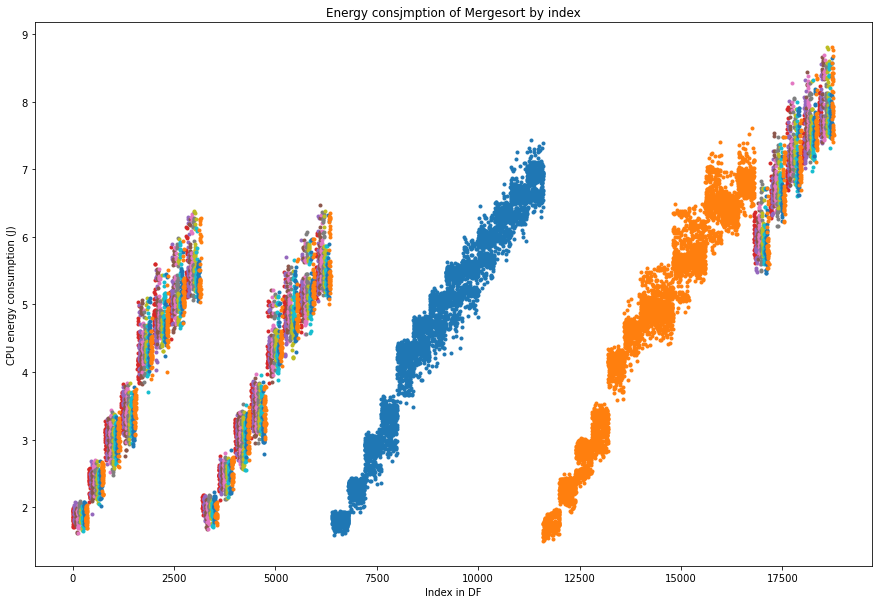

In [125]:

#energy consumption
plt.figure(figsize=(15,10))
plt.plot(dfBest["CPU (J)"], ".")
plt.plot(dfWorst["CPU (J)"],".")
for i in range(10):
    plt.plot(listOfRandoms[i]["CPU (J)"],".")
plt.title("Energy consjmption of Mergesort by index")
plt.xlabel("Index in DF")
plt.ylabel("CPU energy consumption (J)")
plt.show()

Since this shows us very little, we further seperate data by size, and consider size as x-axis. Although since size is a very descrete value, we see on the graph below that the data is almost placed in columns.
Each column representing a test size, and each dot in each column being a sample of that size. Here, each color represents a different test case: best (green), worst (red), random (orange). This shows the energy consumption rise as the input size rises. 

This can be done to show the rise of time consumption, memory consumption and temperature aswell. 

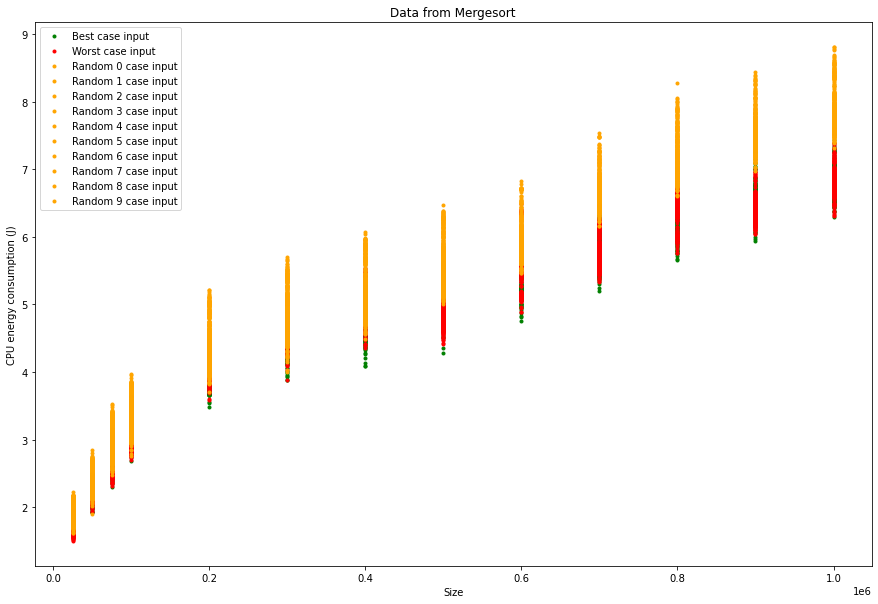

In [126]:
#energy vs size
plt.figure(figsize=(15,10))
plt.plot(dfBest["Size"], dfBest["CPU (J)"], ".",color = "green", label = "Best case input")
plt.plot(dfWorst["Size"], dfWorst["CPU (J)"],".",color = "red", label = "Worst case input")
for i in range(10):
    plt.plot(listOfRandoms[i]["Size"], listOfRandoms[i]["CPU (J)"],".", color = "orange", label = f"Random {i} case input")
plt.xlabel("Size")
plt.title("Data from Mergesort")
plt.ylabel("CPU energy consumption (J)")
plt.legend()
plt.show()

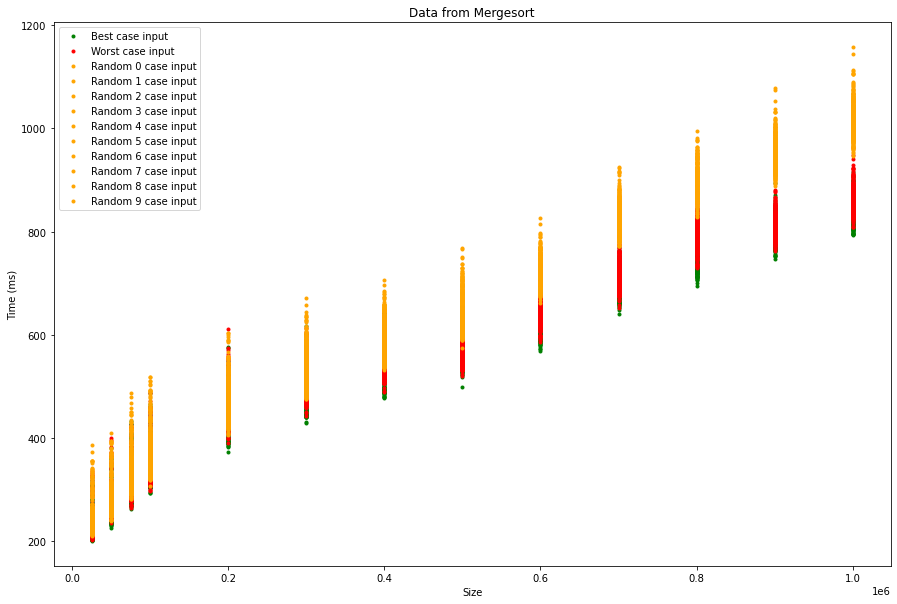

In [127]:
#Time vs size
plt.figure(figsize=(15,10))
plt.plot(dfBest["Size"], dfBest["Time (ms)"], ".",color = "green", label = "Best case input")
plt.plot(dfWorst["Size"], dfWorst["Time (ms)"],".",color = "red", label = "Worst case input")
for i in range(10):
    plt.plot(listOfRandoms[i]["Size"], listOfRandoms[i]["Time (ms)"],".", color = "orange", label = f"Random {i} case input")
plt.xlabel("Size")
plt.title("Data from Mergesort")
plt.ylabel("Time (ms)")
plt.legend()
plt.show()

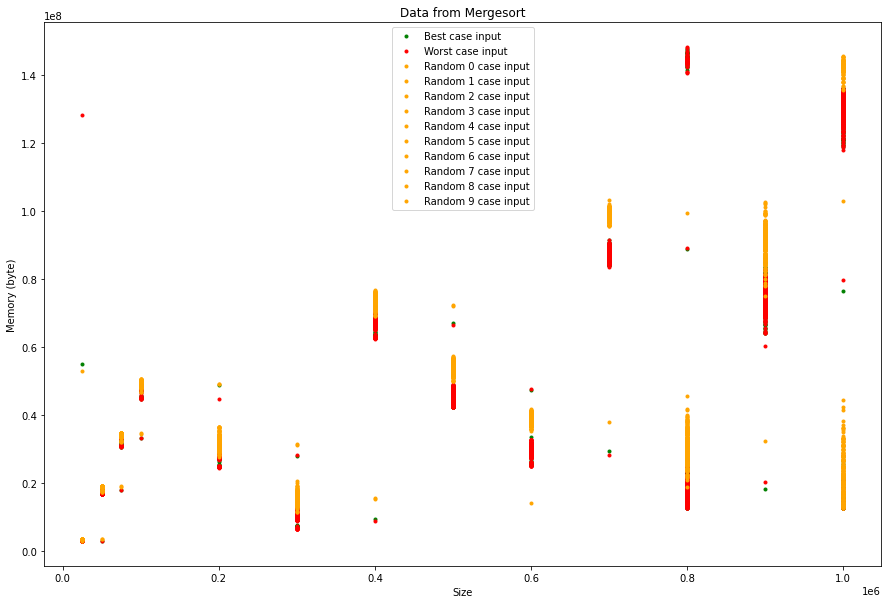

In [128]:
#Memory consumption vs size
plt.figure(figsize=(15,10))
plt.plot(dfBest["Size"], dfBest["Memory (byte)"], ".",color = "green", label = "Best case input")
plt.plot(dfWorst["Size"], dfWorst["Memory (byte)"],".",color = "red", label = "Worst case input")
for i in range(10):
    plt.plot(listOfRandoms[i]["Size"], listOfRandoms[i]["Memory (byte)"],".", color = "orange", label = f"Random {i} case input")
plt.xlabel("Size")
plt.title("Data from Mergesort")
plt.ylabel("Memory (byte)")
plt.legend()
plt.show()

##### Comment for Memory (byte) vs size
For the case of Memory consumption vs size, the test setup must be considered when evaluating the graph above. The mergesort which the measurements were gotten from has been implimented in Java, which has a garbage collector and a JIT which both ensure that memory does not overflow. These two might be the reason for the rather arbitrary look of the memory vs size graph above

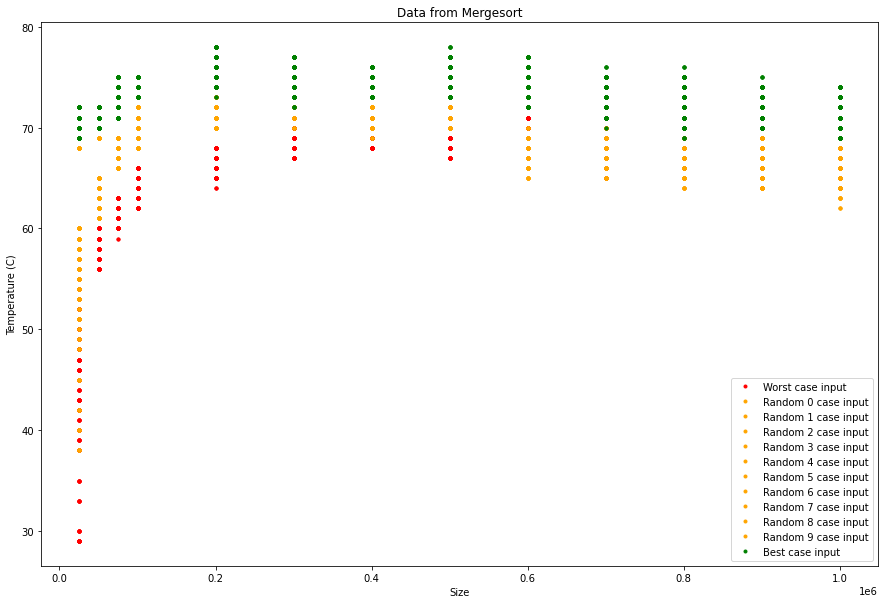

In [129]:
#Temp vs size
plt.figure(figsize=(15,10))
plt.plot(dfWorst["Size"], dfWorst["Temperature"],".",color = "red", label = "Worst case input")
for i in range(10):
    plt.plot(listOfRandoms[i]["Size"], listOfRandoms[i]["Temperature"],".", color = "orange", label = f"Random {i} case input")
plt.plot(dfBest["Size"], dfBest["Temperature"], ".",color = "green", label = "Best case input")
plt.xlabel("Size")
plt.title("Data from Mergesort")
plt.ylabel("Temperature (C)")
plt.legend()
plt.show()

##### Comment for temperature vs size
In the case for the temperature vs size, The data seems to indicate that a  best case input for a small size will make the pc run at a high temperature, although this is not correct. This discrepancy is due to the best being run after the random measurement, making the starting temperature higher for best aswell.  

### Normal distribution
For each of the three cases (best, worst, Random) we consider if the sample groups on each size is normal distributed. Here we use the Shapiro wilk method from scipy.stats

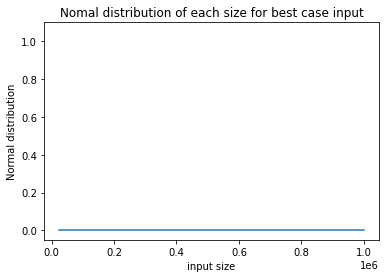

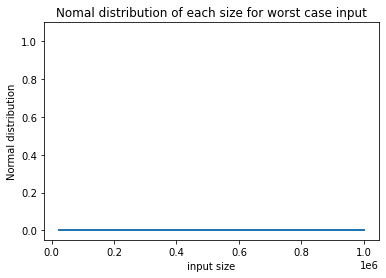

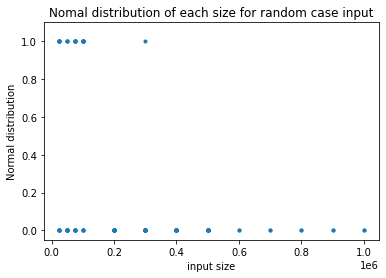

In [130]:
from scipy.stats import shapiro

data = []
size = []

for i in [25000,50000,75000,100000,200000,300000,400000,500000,600000,700000,800000,900000,1000000]:
    #print(f"Size {i}, normal distributed:                           {0.05 < shapiro(dfBest[dfBest['Size'] == i]['CPU (J)']).pvalue}")
    if 0.05 < shapiro(dfBest[dfBest['Size'] == i]['CPU (J)']).pvalue:
        data.append(1)
    else:
        data.append(0)
    size.append(i)
    #plt.hist(dfBest[dfBest['Size'] == i]['CPU (J)'])
    #plt.show()

plt.plot(size,data)
plt.xlabel("input size")
plt.ylabel("Normal distribution")
plt.title("Nomal distribution of each size for best case input")
plt.ylim(-.05,1.10)
plt.show()

#print("worst case input")
for i in [25000,50000,75000,100000,200000,300000,400000,500000,600000,700000,800000,900000,1000000]:
    #print(f"Size {i}, normal distributed:                           {0.05 < shapiro(dfBest[dfBest['Size'] == i]['CPU (J)']).pvalue}")
    if 0.05 < shapiro(dfWorst[dfWorst['Size'] == i]['CPU (J)']).pvalue:
        data.append(1)
    else:
        data.append(0)
    size.append(i)
    #plt.hist(dfBest[dfBest['Size'] == i]['CPU (J)'])
    #plt.show()

plt.plot(size,data)
plt.xlabel("input size")
plt.ylabel("Normal distribution")
plt.title("Nomal distribution of each size for worst case input")
plt.ylim(-.05,1.10)
plt.show()

for i in [25000,50000,75000,100000,200000,300000,400000,500000]:
    for j in range(1,10):
        #print(f"random{j} Size {i}, normal distributed:                     {0.05 < shapiro(listOfRandoms[j][listOfRandoms[j]['Size'] == i]['CPU (J)']).pvalue}")
        #plt.hist(dfBest[dfBest['Size'] == i]['CPU (J)'])
        #plt.show()
        
        if 0.05 < shapiro(listOfRandoms[j][listOfRandoms[j]['Size'] == i]['CPU (J)']).pvalue:
            data.append(1)
        else:
            data.append(0)
        size.append(i)
        #plt.hist(dfBest[dfBest['Size'] == i]['CPU (J)'])
        #plt.show()

plt.plot(size,data, ".")
plt.xlabel("input size")
plt.ylabel("Normal distribution")
plt.title("Nomal distribution of each size for random case input")
plt.ylim(-.05,1.10)
plt.show()

plt.hist(size, )



According to the shapiro test if the returning pValue > 0.05 then the data is normal distrubuted and oppositely if pValue is < 0.05 then the data is not normal distributed. 

here we see that the data is not normal distributed for best case, worst case data is missing ATM, and the larger the input size was, the less fequent normal distributed data occured.

## 4. Data Modelling

In this section, we will be applying some models to the data, in order to evaluate the data against one another. Here we consider that the data is of growth over time, or in our case size. This makes our data continous, and therefor we chose to apply models of type regression. Here there are 4 different types to evaluate, Linear regression, polunomial regression, Logistic regression and Decision Tree regressor. Once each type of regression is implimented, they are evaluated through their $R^2$ value.


### 4.1. Feature Selection

To compare energy, time and memory consumption of algorithms to eachother, we make a polynomial regression. 
When making a polynomial regression it is important to evaluate which degree the polynomial is at.

This can be done with metrics.r2_score(y, y_poly) on each degree. This will return a fitness value, in the form of a procentage represented as a float. Where 1.00 is 100% accuracy  


#### Structure of 4:
-   Best Time vs Size 
-   Worst Time vs Size
-   Random Time vs Size
    - Description of best degree for time
-   Best CPU energy consumption vs Size
-   Worst CPU energy consumption vs Size
-   Random CPU energy consumption vs Size
    - Description of best degree for CPU energy consumption


#### structure of 4
-   4.1 choose which parameters we use for the multiple 'models'
-   4.2 create loads of models (Poly, Liniear, DTR, Logit) and evaluate {R^2}
-   4.3 apply the model with the highest r2 value from 4.2 and use "extensive evaluation" to further judge if the model fits (what ever that means) 
-   4.4 plot the model


All paramaters except GPU (J) of the data will be evaluated. PKG (J) is a measure of system energy use while CPU (J) and memory (J) are more specific. Time (ms) is connected to CPU (J) and memory (bytes) is connected to memory (J). Temperature is relavant for all energy measurements. Test name and size seperates the data accordingly.
Once evaluated we can compare and discuss corralation.

All paramaters except GPU (J) of the data will be evaluated. PKG (J) is a measure of system energy use while CPU (J) and memory (J) are more specific. Time (ms) is connected to CPU (J) and memory (bytes) is connected to memory (J). Temperature is relavant for all energy measurements. Test name and size seperates the data accordingly.
Once evaluated we can compare and discuss corralation.

### 4.2 Model Construction and Validation

[Construct the model and validate the model design if necessary.]

### Polynomial Regression ###

In [131]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
from operator import itemgetter

def polyReg(SeriesX, SeriesY,maxDegrees, Label, color, minDegrees = 2, plotLabel = True, printR2Score = True, plotGraph = True):
    X = SeriesX.values.reshape(SeriesX.size, -1)
    y = SeriesY.values

    colors = ["white","black","purple",color , 'cyan', 'yellowgreen', 'gold', color,'green','violet']

    fitness = []
    for dg in range(minDegrees, maxDegrees):
        # Create an empty polynomial function with degree of 4
        poly_reg = PolynomialFeatures(degree=dg)
        # Fit the function to the X and transform X to the polynomial format
        X_poly = poly_reg.fit_transform(X)

        # Now we construct a Multiple Linear Regressor on the transformed X_ploy
        lr_2 = LinearRegression()  
        lr_2.fit(X_poly, y)  
        
        # Get the y values using the constructed Multiple Linear Regressor
        y_poly = lr_2.predict(X_poly)
        r2 = metrics.r2_score(y,y_poly)
        #if printR2Score:
        #    print(f"r2_score for {Label} {dg} is: {r2}")
        fitness.append((f"poly {dg}dg", r2, y_poly))
        #print(f"Parameters of poly: {poly_reg.get_params()}") #does not give what we are looking for
    
    if plotGraph:
        plt.scatter(X, y, color=color, label=Label)
        plt.legend(loc='upper left')
        plt.plot(X, y_poly, color=color,label= Label, linewidth=2)
    return max(fitness,key=itemgetter(1))
        


### Linear Regression ###

In [132]:
import statsmodels.formula.api as smf

def linReg(SeriesX, SeriesY, Label, color, minDegrees = 1, plotLabel = True, printR2Score = True, plotGraph = True ):
    return polyReg(SeriesX, SeriesY, 2, Label, color, minDegrees=minDegrees, plotLabel=plotLabel, printR2Score=printR2Score, plotGraph=plotGraph)

### DTR ###

In [133]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor    # Import decision tree regression model


def dtr(SeriesX, SeriesY, Label, color, plotLabel = True, printR2Score = True, plotGraph = True ):
    X = SeriesX
    y = SeriesY
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)
    # Sort X and y by ascending values of X
    X_train = X_train.sort_values(by=['Size'])
    #return y_train, X_train.index
    y_train = y_train[X_train.index]

    # Initialize and fit regressor
    dtRegressor = DecisionTreeRegressor(criterion='squared_error', max_depth=3)         
    dtRegressor.fit(X_train, y_train)

    y_pred = dtRegressor.predict(X_test)
    #y_plot = plt.plot(X, y_pred, color=color,label= Label, linewidth=2)

    #if printR2Score:
    #    print("hel")
    return ("DTR",metrics.r2_score(y_test,y_pred), y_pred)

#### Logistic regression

This regression technique is not implimented. This is due to the nature of the logistic regression. This regression method will create a logistic regression spaning over binary data. This can be very useful for estimating dianosis in medicin, but since the data gathered in this project is not binary, we omit the use of Logistic regression.

In [134]:
#plt.figure(figsize=(15, 10))
def bestReg(df, name, column):
    pfit = polyReg(df["Size"], df[column], 10, "Best", "red", plotGraph=False)
    lfit = linReg(df["Size"], df[column], "Best", "blue", plotGraph=False)
    dfit  = dtr(df[["Size"]], df[column], "Best DTR", "green", plotGraph=False)

    print(f"Best regression for {name} on {column} is {max([pfit, lfit, dfit],key=itemgetter(1))}")
    

In [135]:

bestReg(dfBest, "best case","Time (ms)")
bestReg(dfWorst, "worst case","Time (ms)")
for i in range(1,len(listOfRandoms)):
    bestReg(listOfRandoms[i], f"random {i}","Time (ms)")

print("\n")

bestReg(dfBest, "best case","CPU (J)")
bestReg(dfWorst, "worst case", "CPU (J)")
for i in range(1,len(listOfRandoms)):
    bestReg(listOfRandoms[i], f"random {i}","CPU (J)")
    
print("\n")

bestReg(dfBest, "best case", "Memory (byte)")
bestReg(dfWorst, "worst case", "Memory (byte)")
for i in range(1,len(listOfRandoms)):
    bestReg(listOfRandoms[i], f"random {i}","Memory (byte)")

print("\n")

bestReg(dfBest, "best case","Temperature")
bestReg(dfWorst, "worst case", "Temperature")
for i in range(1,len(listOfRandoms)):
    bestReg(listOfRandoms[i], f"random {i}","Temperature")

Best regression for best case on Time (ms) is ('poly 3dg', 0.9755994047348076)
Best regression for worst case on Time (ms) is ('DTR', 0.9754995640909658)
Best regression for random 1 on Time (ms) is ('DTR', 0.9760110780225293)
Best regression for random 2 on Time (ms) is ('DTR', 0.976439378624369)
Best regression for random 3 on Time (ms) is ('poly 3dg', 0.9762129417205461)
Best regression for random 4 on Time (ms) is ('DTR', 0.9748792491575612)
Best regression for random 5 on Time (ms) is ('poly 3dg', 0.9770826977426703)
Best regression for random 6 on Time (ms) is ('poly 3dg', 0.9779752983739736)
Best regression for random 7 on Time (ms) is ('poly 3dg', 0.9751357975247555)
Best regression for random 8 on Time (ms) is ('DTR', 0.9747052325860943)
Best regression for random 9 on Time (ms) is ('poly 3dg', 0.9768191301295461)
Best regression for random 10 on Time (ms) is ('poly 3dg', 0.9767436436593606)


Best regression for best case on CPU (J) is ('poly 3dg', 0.9731934337779167)
Best re

Since the best r2_score for the Best case input is 0.980542818732591 which is greater than the others. 

That means that Degree 3 polynomial is the best fit for the data for best case input.

### 4.3 Model Application and Performance Evaluation

[Apply the model and evaluate its performance] {SPLIT DATASET INTO TRAINING(80%) AND VALIDATION(20%) AND DO SOME ML VALIDATION}

In [ ]:

def validateModel(SeriesX, SeriesY, reg):
    X_train, X_test, y_train, y_test = train_test_split(SeriesX, SeriesY, test_size = 0.20)
    
    if reg == 'poly':
        model = polyReg(X_train,y_train,4,"poly","red",3, plotGraph=False)[2]

    if reg == 'dtr':
        model = dtr(X_train,y_train, "dtr", "red", plotGraph=False)[2]
    
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, model))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, model))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, model)))

In [ ]:
for i in 

### 4.4 Visualize and Analyze Your Results/Findings from Data Modelling

In this section we will fist plot each graph individually, including their models, ie. (Size, Time(ms)) (Size, Memory(byte)), (Size, CPU (J)), (Time, Temperature)

#### Size vs CPU energy consumption

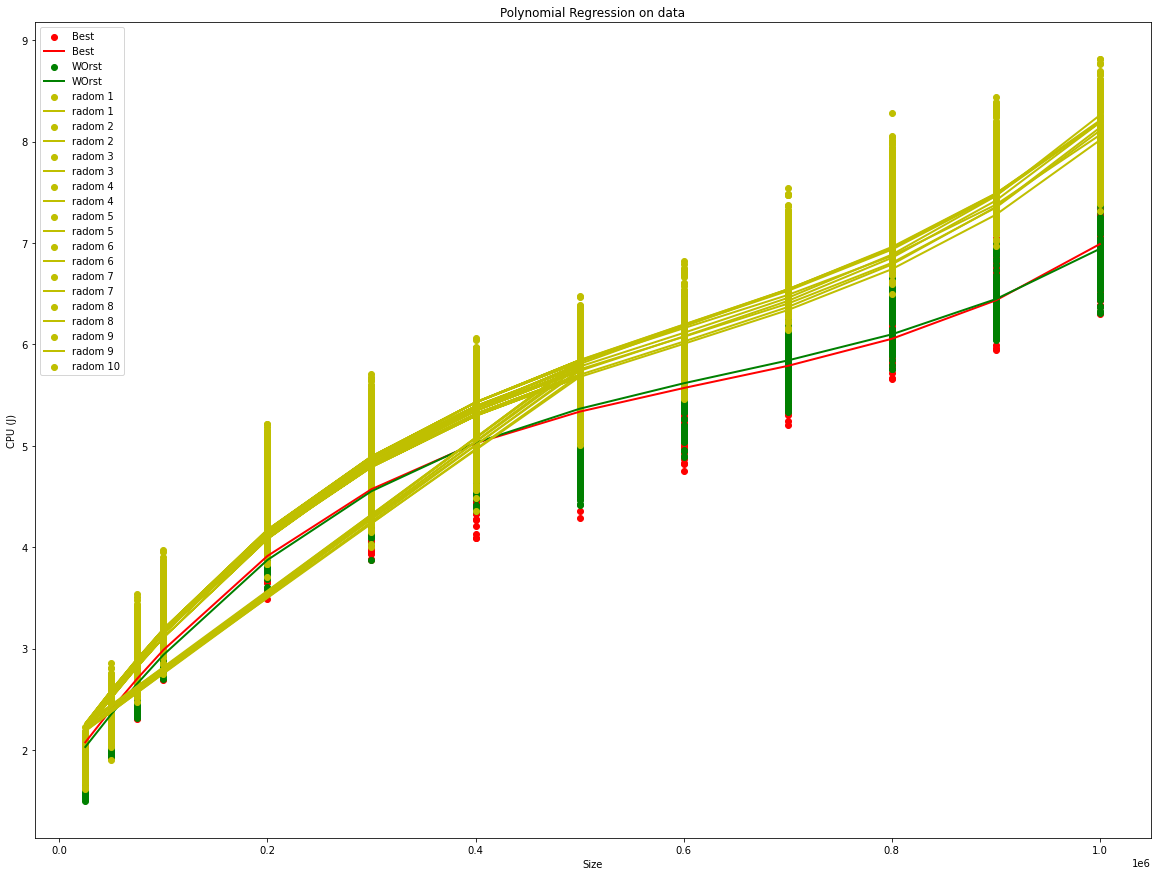

In [147]:
plt.figure(figsize=(20, 15))
polyReg(dfBest["Size"], dfBest["CPU (J)"], 4, "Best", "red", minDegrees=3, printR2Score=False)
polyReg(dfWorst["Size"], dfWorst["CPU (J)"], 4, "WOrst", "green", minDegrees=3, printR2Score=False)

for i in range(1,11):
    polyReg(listOfRandoms[i]["Size"], listOfRandoms[i]["CPU (J)"], 4, f"radom {i}", "y", minDegrees=3, printR2Score=False, plotGraph=True)
plt.title('Polynomial Regression on data')
plt.xlabel('Size')
plt.ylabel('CPU (J)')
plt.show()

##### Size vs Time (ms)

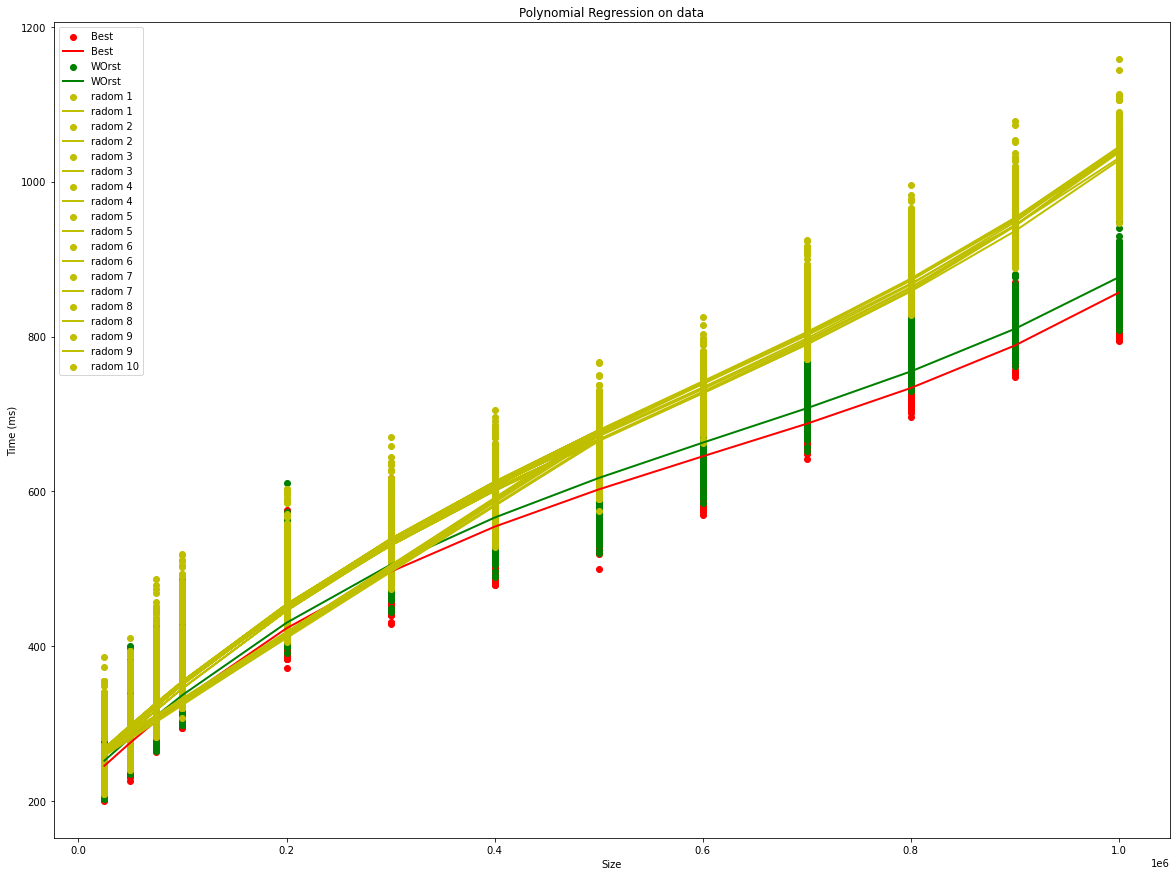

In [148]:
plt.figure(figsize=(20, 15))
polyReg(dfBest["Size"], dfBest["Time (ms)"], 4, "Best", "red", minDegrees=3, printR2Score=False)
polyReg(dfWorst["Size"], dfWorst["Time (ms)"], 4, "WOrst", "green", minDegrees=3, printR2Score=False)

for i in range(1,11):
    polyReg(listOfRandoms[i]["Size"], listOfRandoms[i]["Time (ms)"], 4, f"radom {i}", "y", minDegrees=3, printR2Score=False, plotGraph=True)
plt.title('Polynomial Regression on data')
plt.xlabel('Size')
plt.ylabel('Time (ms)')
plt.show()

#### DTR of Size vs Memory comsumption

In [152]:
dtr(df[["Size"]], df[column], "Best DTR", "green", plotGraph=False)

NameError: name 'column' is not defined

#### DTR of Time (ms) vs Temperature

In [151]:
dtr(df[["Size"]], df[column], "Best DTR", "green", plotGraph=False)

NameError: name 'column' is not defined

## 5. Conclusion and Discussion

[Here you may draw your conclusion based on the previous sections, and discuss the pros and cons of the project, and propose something for future work.]